# ДЗ 03. ML для бизнеса

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

2. Подберите параметры модели SARIMAX для этого ряда.

3. Сделайте вывод о том, как изменилась модель по сравнению с недельной.

4. Возмите вариант 1 или 2 
    * 	Вариант 1) - Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)
    * 	Вариант 2) - Постройте ACF, PACF и модель ARIMA для СOVID_19 (по любой стране кроме Китая на дневных графиках )

5. Оцените результат моделирования

6. Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

p.s Начать стоит с разбора ноутбука Временные ряды 3.ipynb, т.к SARIMA мы не успели на занятии пройти основательно и так будет проще сделать ДЗ. Также для сравнения качества моделей можно попробовать какой-нибудь критерий (из тех что разобрали в начале): AIC, BIC, F-test, R2 и т.д

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

/Users/artem/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Задание 1

Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

In [2]:
df = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])
df.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


Делаем ресемплинг на месяц:

In [3]:
df_month = df.copy()
df_month = df_month.resample("M").mean()

Делаем ресемплинг по неделям:

In [4]:
df_week = df.copy()
df_week = df_week.resample('W').mean()

## Задание 2

Подберите параметры модели SARIMAX для этого ряда.

**Определим параметры SARIMAX**. 

Рассмотрим результаты моделирования ряда с потенциально хорошими значениями порядками компонент нашего ряда с учетом сезонности в модификации SARIMAX, которая кроме всего прочего строит сезонную составляющую ряда. Фактически строим 3 модели : модель сезона и модель вокруг сезонных колебаний. А наш ряд очевидно сезонный. В качестве метрики качества используем информационный критерий Акаике (AIC) - чем меньше, тем лучше.

Обозначения для модели включают указание порядка для моделей AR (p), I (d) и MA (q) в качестве параметров функции ARIMA и AR (P), I (D), MA (Q) и m. параметры на сезонном уровне, например SARIMA (p, d, q) (P, D, Q) m, где «m» - количество временных шагов в каждом сезоне (сезонный период). Модель SARIMA может использоваться для разработки моделей AR, MA, ARMA и ARIMA. Принципиально формат обращения остается прежним (как у ARIMA), за исключением добавки сезонных параметров SARIMAX(<данные - массив ряда>,order=[p,d,q], seasonal_order=[ps,ds,qs])\

In [5]:
import warnings

# Определим p, d и q 
q = 2
p = 1
d = 1
pdq = [p, d, q]

# определим комбинации сезонных параметров p, q и q, 
#будем работать с недельными данными, тогда сезонность это 26 недель
qs = 1
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,12] 

In [6]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [1, 1, 2]    : ps,ds,qs, S= [0, 0, 1, 12]


In [7]:
#для построения модели используем все данные, кроме 12-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[:-12],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[1, 1, 2]x[0, 0, 1, 12] - AIC:3139.7080118252484


In [8]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(1, 1, 2)x(0, 0, 1, 12)   Log Likelihood               -1564.854
Date:                            Mon, 13 Jul 2020   AIC                           3139.708
Time:                                    14:35:17   BIC                           3155.445
Sample:                                         0   HQIC                          3146.093
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Теперь организуем перебор параметров с целью поиска минимального значения AIC:

In [9]:
import itertools

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = [0] 
d = [0,1]
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 0, 12)
SARIMAX: (0, 0, 2) x (0, 0, 1, 12)


In [10]:
df_month['PJME_MW'].values.shape

(200,)

Организуем цикл для сбора параметров в список для последующей их оценки:

In [16]:
res_list = []
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[:-12],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            item = {'param':param, 'param_season':param_seasonal,'aic':results.aic}
            res_list.append(item)
            #print(item)
            #print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Создадим датафрейм с параметрами и AIC и отсортируем по AIC:

In [17]:
month_results = pd.DataFrame(res_list)

In [18]:
month_results.sort_values(by=['aic'])

,param,param_season,aic
35,"(0, 1, 2)","(0, 1, 2, 12)",2613.007537
89,"(1, 1, 2)","(0, 1, 2, 12)",2614.734792
143,"(2, 1, 2)","(0, 1, 2, 12)",2624.322716
83,"(1, 1, 1)","(0, 1, 2, 12)",2630.284748
137,"(2, 1, 1)","(0, 1, 2, 12)",2632.299203
...,...,...,...
7,"(0, 0, 1)","(0, 0, 1, 12)",4012.922622
1,"(0, 0, 0)","(0, 0, 1, 12)",4015.360574
12,"(0, 0, 2)","(0, 0, 0, 12)",4206.520030
6,"(0, 0, 1)","(0, 0, 0, 12)",4259.479361


Выбираем лучшие параметры: param = (0, 1, 2), param_seasonal = (0, 1, 2, 12)

In [19]:
#для построения модели используем все данные, кроме 3-х последних месяцев (это будет тестовый набор)
warnings.filterwarnings("ignore") # отключает предупреждения

mod = sm.tsa.statespace.SARIMAX(df_month['PJME_MW'].values[:-12],order=[0,1,2],
                                seasonal_order=[0,1,2,12] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print('AIC:{}',results_opt.aic)

AIC:{} 2613.0075365706925


In [20]:
print(results.summary().tables[0],results.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  188
Model:             SARIMAX(2, 2, 2)x(0, 1, 2, 12)   Log Likelihood               -1311.741
Date:                            Mon, 13 Jul 2020   AIC                           2637.481
Time:                                    14:53:50   BIC                           2658.414
Sample:                                         0   HQIC                          2645.987
                                            - 188                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

Отобразим на графике результаты модели:

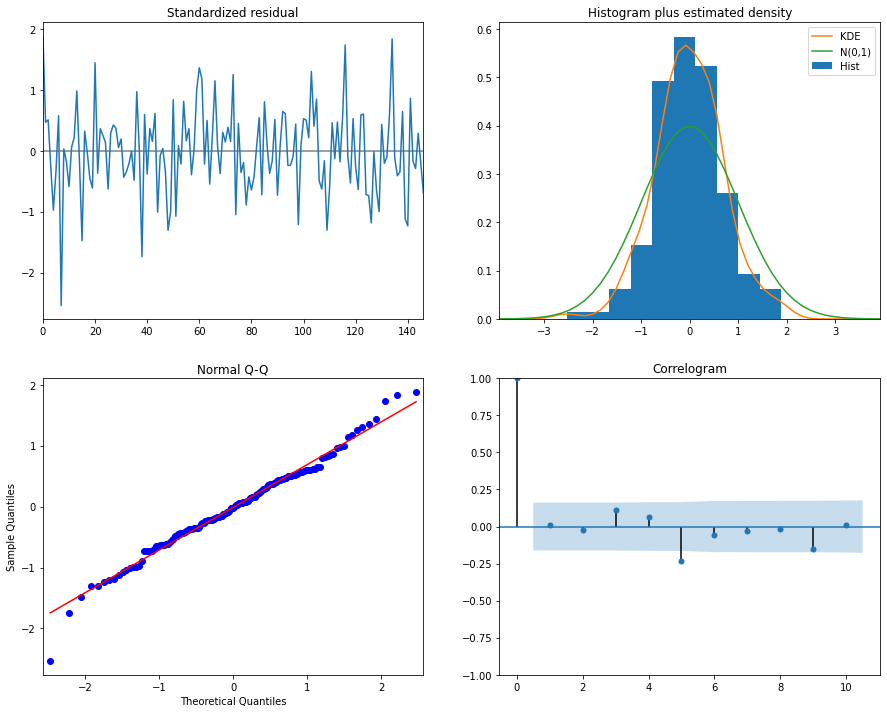

In [34]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

Сделаем предсказание:

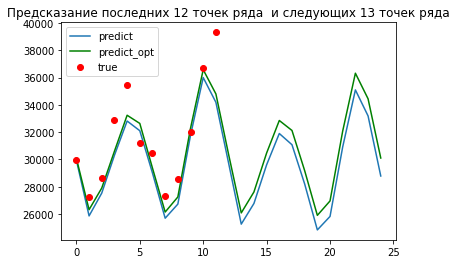

In [33]:
pred_dynamic = results.forecast(25)    #делаем предсказание на 25 точек от текущего конца ряда
pred_dynamic_opt = results_opt.forecast(25)

plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(df_month['PJME_MW'].values[-12:],'or',label='true')
plt.title('Предсказание последних 12 точек ряда  и следующих 13 точек ряда')
plt.legend()

plt.show()

## Задание 3

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

"Недельная" модель представлена в ноутбуке "Временные ряды 3" к уроку

На графике предсказания месячная модель оказывается визуально точнее, чем недельная.

AIC месячных данных "лучше", чем недельных: 2613 вместо 7316.

Коэффициент модели ar.L2 имеет малое абсолютное значение, что свидетельствует о том, что он не играет роли при определении ответа модели. посмотрим на визуализацию результатов работы модели, где видно, что остатки ряда распределены не одинаково на краях модели и в ее основной части, что не позволит принимать правильное решение (рис.Normal Q-Q, Standardized rezidual)
    
    
Если смотреть на графики, то видно, что месячные данные более близки к нормально распределённым, чем недельные (Q-Q график и Гистограмма)

## Задание 4

Постройте ACF, PACF и модель ARIMA для BRENT (недельный ресемплинг)

In [92]:
brent = pd.read_csv('my_BRENT2019.csv', index_col=[0], parse_dates =[0])
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [93]:
brent_week = brent.copy()
brent_week = brent_week.resample('W').mean()
brent_week.tail()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2019-08-04,62.791667,2019.0,7.500000,16.166667,3.0,212.666667,31.0,2.666667,0.0,0.000000,0.0
2019-08-11,58.236667,2019.0,8.000000,7.666667,3.0,219.666667,32.0,2.666667,0.0,0.000000,0.0
2019-08-18,59.033333,2019.0,8.000000,14.666667,3.0,226.666667,33.0,2.666667,0.0,0.000000,0.0
2019-08-25,59.495000,2019.0,8.000000,21.666667,3.0,233.666667,34.0,2.666667,0.0,0.000000,0.0
2019-09-01,59.348333,2019.0,8.166667,23.500000,3.0,240.666667,35.0,2.666667,0.0,0.166667,0.0


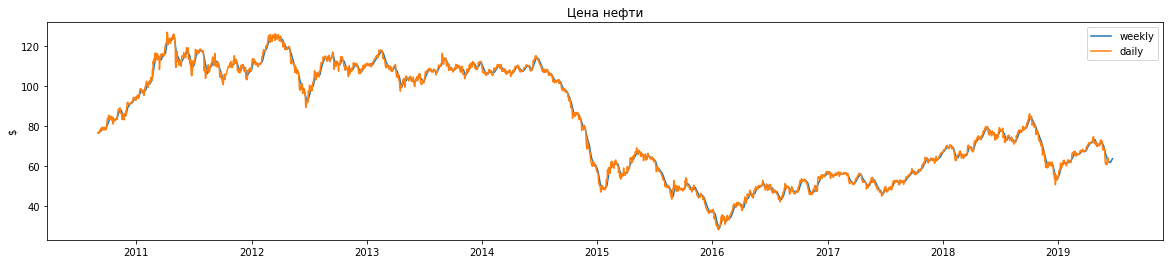

In [94]:
plt.figure(figsize =(20,4))
plt.plot(brent_week.index[:-10], brent_week['Значение'].values[:-10], label='weekly')
plt.plot(brent.index[:-70], brent['Значение'].values[:-70], label='daily')
plt.title('Цена нефти' )
plt.ylabel ( '$' )
plt.legend()
plt.show()

In [96]:
brent_week = brent_week.dropna()

In [97]:
brent_week[brent_week.isna().any(axis=1)]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,


In [98]:
model = sm.tsa.ARIMA(brent_week['Значение'], order=(2,0,1))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Значение   No. Observations:                  469
Model:                     ARMA(2, 1)   Log Likelihood               -1019.389
Method:                       css-mle   S.D. of innovations              2.115
Date:                Mon, 13 Jul 2020   AIC                           2048.777
Time:                        18:13:38   BIC                           2069.530
Sample:                             0   HQIC                          2056.943
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             75.9226     15.057      5.042      0.000      46.412     105.433
ar.L1.Значение     1.0267      0.148      6.952      0.000       0.737       1.316
ar.L2.Значение    -0.0336      0.147     -0.229      0.819      -0.322       0.255
ma.L1.Значение     0.3326      0.142      2.341      0.020       0.054       0.611
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0072           +0.0000j            1.0072            0.0000
AR.2           29.5199           +0.0000j           29.5199            0.0000
MA.1           -3.0064           +0.0000j            3.0064            0.5000
-----------------------------------------------------------------------------
"""

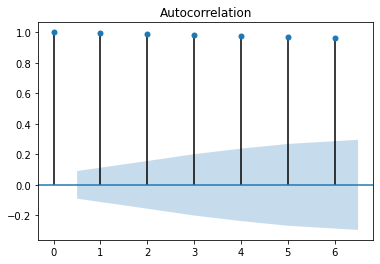

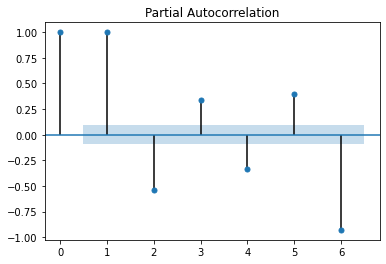

In [103]:
#plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(brent_week['Значение'].values, lags=6)
plt.show()

#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_week['Значение'].values, lags=6)
plt.show()

## Задание 5

Получили оценку автокорреляции недельной модели по иcходному ряду и его первым разностям. Для этой модели не получается увидеть автокорреляцию с лагом 4 недели.
Но можно увидеть корреляцию остатков по первым двум лагам (Partial Autocorrelation)

## Задание 6

Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

- У меня пока нет понимания этой темы, поэтому не могу сказать, какая модель лучше работает с техниками регрессии на основе AR I MA. Хотелось бы такие темы разбирать поглубже!